# data-discovery

The purpose of this notebook will be to answer several important questions about our data set, which must be answered before we start build any models.

Those questions include:
- What assumptions can we make about the data?
- What is the quality of the data, and if the quality is low, what can we do about it?
- What are the data types?
- What does the data look and feel like?
- Should any features be removed before they are ingested into our models into our models?

The data used in this notebook has been altered slightly from the raw .json.gz's that we are using as our absolute source of truth. There are no actual transformations to the data, just an unzipping and repacking of the data to make it more accessible. The transformation is done within `_00_unzip_and_repackage.py`.

### install dependancies

In [2]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

## read in the data

Let's read in our data from the creditcard.parquet file in the data folder. The original .csv has been reformatted to specify data types and reduce the size of the file. The code that was used to do this is included in the scripts folder. 

In [4]:
# read in data from parquet
df = pl.read_parquet('../data/00_products_labeled.parquet')

# display a few rows of the dataframe
display(df.head(3))

Category,Price,Title,Features,Description,Details,SKU,Manufacturer
str,f64,str,list[str],list[str],struct[172],str,str
"""Automotive""",null,"""Bosal 813-767 Exhaust Pipe""","[""Package Dimensions: 5.0 H x 44.0 L x 8.0 W (inches)"", ""Easy Installation"", … ""Country of Origin : United States""]","[""One piece, direct fit exhaust system component that saves installation time by eliminating the need for labor intensive bending and welding required with split system exhaust components.""]","{""Bosal"",""Bosal"",""6.85 pounds"",""44""L x 8""W"",""813-767"",""813-767"",{2432472,null,null,4897,5406,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null},""December 15, 2007"",""Round"",""Bolt-On"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""813-767""","""Bosal"""
"""Automotive""",null,"""NICEASY Bling Diamond Steering…","[""【Fashionable Design】Fashion charming design of the diamond steering wheel cover, bling under the light, sparkling through windshield and shining your car.Simple Elegant Design style,Excellent Gift for Man Woman Girl Mom Wife"", ""【Eco-friendly & Healthy】Our bling steering wheel covers are totally eco-friendly and healthy. PU leather with rhinestone bling design add fashion to your car interior, make your car personalized. Top diamond craftwork, more stable, will not hurt your hands."", … ""【Absolutely 100% Customer Satisfaction Service 】If you are not satisfied with your purchase of Steering wheel cover , please feel free to contact us anytime and anywhere.""]","[""【Fashionable Design】Fashion charming design of the diamond steering wheel cover, bling under the light, sparkling through windshield and shining your car."", ""【Eco-friendly & Healthy】Our bling steering wheel covers are totally eco-friendly and healthy. PU leather with rhinestone bling design add fashion to your car interior, make your car personalized. Top diamond craftwork, more stable, will not hurt your hands."", … ""【Absolutely 100% Customer Satisfaction Service 】If you are not satisfied with your purchase of Steering wheel cover , please feel free to contact us anytime and anywhere.""]","{""Hi-Well"",""NICEASY"",""1.5 pounds"",null,null,""NEYSWC1"",{1032865,3212,4369,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null},""June 27, 2020"",null,null,""15.8 x 15.8 x 1.8 inches"","""",""Vehicle Service Type Car"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,n

### data at a glance

Just from looking at a few elements in this dataset I can tell this is going to be a feature engineering problem. Sometimes you get lucky and you get a high quality, homogenous data set that contains several valuable numeric fields that have reasonable distrubitions. Not here. No sir. Without going 1 step further I can tell that at least 80% of the work getting value out of this model is going to be beating and bending these elements in something useful.

Here are some other early observations:
- mixed data types (string, float, lists, nested structures)
- high missingness rate in some fields (particularly Price)
- inconsistent elements between rows (varying Detail field structures)
- extremely sparse data in the Details field (many null values)
- heterogeneous text data formats (titles, features as lists, descriptions as lists)
- variable length text fields (particularly in Features and Description)
- nested/hierarchical data structures that will require flattening or specialized processing
- truncated values that may be missing information
- diverse product attributes that vary 

I can also tell that what is now the details column is essentially it's own nested datframe that contains many more rows that the root level columns, so let's go ahead and break that off before we start digging deeper.

In [6]:
# seperate columns at root level from details
root_df = df.drop('Details')

# break otu details into it's own dataframe
details_df =  df.select(pl.col("Details").struct.field('*'))

## null values, data types, and distinct values

There are three things I normally want to now first about any data set I'm analyzing.

- data types
    - specifically, I want to know if the data is categorical or numeric
    - this will have a large impact on the model chosen, especially with regard to the dependant variable
- null values
    - how many elements in a column are null, NaN, empty
- distinct values
    - how many distinct values are there for each field

### data types

In [22]:
# Create a dataframe from dtypes
root_dtype_list = [(col, str(dtype)) for col, dtype in zip(root_df.columns, root_df.dtypes)]
root_dtype = pd.DataFrame(root_dtype_list, columns=['Column', 'Data Type'])

# Display the result
print("root dataframe dtypes")
display(root_dtype)

# repeat for details
details_dtype_list = [(col, str(dtype)) for col, dtype in zip(details_df.columns, details_df.dtypes)]
details_dtype = pd.DataFrame(details_dtype_list, columns=['Column', 'Data Type'])

# Reorganize into groups of 25
num_cols = len(details_dtype)
group_size = 25
num_groups = (num_cols + group_size - 1) // group_size

# Create compact display dataframe
compact_df = pd.DataFrame()

for i in range(num_groups):
   start_idx = i * group_size
   end_idx = min(start_idx + group_size, num_cols)
   
   group_data = details_dtype.iloc[start_idx:end_idx].reset_index(drop=True)
   
   # Add to result dataframe
   if i == 0:
       compact_df = group_data
   else:
       # Rename columns for additional groups
       group_data.columns = [f'Column_{i+1}', f'Data Type_{i+1}']
       compact_df = pd.concat([compact_df, group_data], axis=1)

# Display result
display(compact_df)

print("details datfarem dtypes")


root dataframe dtypes


,Column,Data Type
0,Category,String
1,Price,Float64
2,Title,String
3,Features,List(String)
4,Description,List(String)
5,SKU,String
6,Manufacturer,String


,Column,Data Type,Column_2,Data Type_2,Column_3,Data Type_3,Column_4,Data Type_4,Column_5,Data Type_5,Column_6,Data Type_6,Column_7,Data Type_7
0,Manufacturer,String,Item Package Dimensions L x W x H,String,Hardware Platform,String,Product Care Instructions,String,Occasion,String,Suggested Users,String,Number of Handles,String
1,Brand,String,Package Weight,String,Flash Memory Size,String,Collection Name,String,Number of Sets,String,Sport Type,String,Style Classic,String
2,Item Weight,String,Item Dimensions LxWxH,String,Hard Drive Interface,String,Assembly required,String,Corner Style,String,Hand Orientation,String,Finish Type Powder Coated,String
3,Product Dimensions,String,Brand Name,String,Digital Storage Capacity,String,Number of pieces,String,Weight,String,Import,String,Auto Part Position,String
4,Item model number,String,Material,String,Hard Disk Interface,String,Batteries required,String,Duration,String,Frame Type,String,Fill Material,String
5,Manufacturer Part Number,String,Part Number,String,Connectivity Technology,String,Telephone Type,String,External Testing Certification,String,Voltage,String,Pillow Type,String
6,Best Sellers Rank,"Struct({'Automotive': Int64, 'Steering Wheel C...",Model Year,String,Special Feature,String,Answering System Type,String,Product Benefits,String,Plug Format,String,Item Firmness Description,String
7,Date First Available,String,Theme,String,Hard Disk Form Factor,String,Multiline Operation,String,Position,String,Handle Material,String,Model Name,String
8,Shape,String,Age Range (Description),String,Hard Disk Description,String,Caller Identification,String,Vehicle Service Type,String,Closure,String,Thread Count,String
9,Installation Type,String,Package Type,String,Item Package Quantity,String,Fabric Type,String,OEM Part Number,String,Material Type,String,Item Display Dimensions,String


details datfarem dtypes


Main dataframe structure:
- Core fields use consistent types (strings, float64 for Price)
- Text fields use string or list-of-string types
- All identifier fields are strings

Details dataframe structure:
- Contains 172 attributes as separate columns
- Almost entirely string-typed despite containing numeric data
- Contains NaN values in bottom rows
- Includes struct field with nested information
- Contains redundant columns (multiple dimension fields)
- Includes dates stored as strings
- Contains boolean concepts as strings ("Is Dishwasher Safe")
- Multiple columns represent the same concept (dimensions, weight)

Data characteristics:
- String fields contain numeric values
- Temporal data stored as text
- Categorical information spread across many columns
- Inconsistent representation of similar data points

### nulls

In [ ]:
# calculate nulls and null perctangates
nulls = root_df.null_count().unpivot(
    variable_name='column',
    value_name='null_count'
).with_columns(
    null_percentage = (pl.col('null_count')/df.height)*100
).sort(by='null_percentage', descending=False)

# stylized output 
styled_nulls = (nulls.to_pandas()
    .style
    .background_gradient(subset=['null_percentage'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['null_percentage'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'null_percentage': '{:,.2f}%'})  # Format numbers
    .set_caption('root nulls')
)

display(styled_nulls)

,column,null_count,null_percentage
0,Category,0,0.00%
1,Title,0,0.00%
2,Features,0,0.00%
3,Description,0,0.00%
4,SKU,0,0.00%
5,Manufacturer,0,0.00%
6,Price,24857,58.58%


In [ ]:
# details null percentages
# calculate nulls and null perctangates
nulls = details_df.null_count().unpivot(
    variable_name='column',
    value_name='null_count'
).with_columns(
    null_percentage = (pl.col('null_count')/df.height)*100
).filter(
    pl.col('null_percentage') <= 90
).sort(by='null_percentage', descending=False)

# stylized output 
styled_nulls = (nulls.to_pandas()
    .style
    .background_gradient(subset=['null_percentage'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['null_percentage'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'null_percentage': '{:,.2f}%'})  # Format numbers
    .set_caption('details nulls w/null_percentage <= %90')
)

display(styled_nulls)


,column,null_count,null_percentage
0,Manufacturer,4285,10.10%
1,Date First Available,8586,20.24%
2,Item model number,9395,22.14%
3,Brand,15528,36.60%
4,Item Weight,16232,38.26%
5,Product Dimensions,20036,47.22%
6,Best Sellers Rank,25501,60.10%
7,Is Discontinued By Manufacturer,25878,60.99%
8,Color,26461,62.37%
9,Material,29162,68.73%


- In the main dataframe, Price is the only field with missing values (58.58%)
- All other primary fields (Category, Title, Features, Description, SKU, Manufacturer) are complete
- In the details dataframe, null rates are extremely high across all fields
- Even the most populated detail fields have significant missingness:
    - Manufacturer (10.10%)
    - Date First Available (20.24%)
    - Item model number (22.14%)
- Most detail fields have very high null rates, exceeding 80%
- The data shows a clear pattern of sparsity, particularly in the Details table
- Certain fields like Item Dimensions LxWxH (89.45%) are present in only about 10% of records
- The Details fields appear to vary substantially by product type/category

### distincts

In [ ]:
# calculate unique values and unique value percentages for root_df
distincts = root_df.select([
    pl.all().n_unique()
]).transpose(
    include_header=True,
    column_names=["distinct_count"]
).with_columns(
    distinct_percentage=(pl.col('distinct_count')/df.height)*100
).sort(by='distinct_percentage', descending=True)

# stylize 
styled_distincts = (distincts.to_pandas()
    .style
    .background_gradient(subset=['distinct_percentage'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['distinct_percentage'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'distinct_percentage': '{:,.2f}%'})  # Format numbers
    .set_caption('root distincts')
)

display(styled_distincts)

,column,distinct_count,distinct_percentage
0,Title,42362,99.84%
1,SKU,41484,97.77%
2,Features,35322,83.25%
3,Description,29145,68.69%
4,Manufacturer,28041,66.09%
5,Price,5288,12.46%
6,Category,28,0.07%


In [ ]:
# calculate unique values and unique value percentages for root_df
distincts = details_df.select([
    pl.all().n_unique()
]).transpose(
    include_header=True,
    column_names=["distinct_count"]
).with_columns(
    distinct_percentage=(pl.col('distinct_count')/df.height)*100
).sort(by='distinct_percentage', descending=True)

# stylize 
styled_distincts = (distincts.to_pandas()
    .style
    .background_gradient(subset=['distinct_percentage'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['distinct_percentage'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'distinct_percentage': '{:,.2f}%'})  # Format numbers
    .set_caption('details distincts')
)

display(styled_distincts)

,column,distinct_count,distinct_percentage
0,Item model number,32258,76.03%
1,Manufacturer,25164,59.31%
2,Product Dimensions,19622,46.25%
3,Brand,18424,43.42%
4,Best Sellers Rank,13789,32.50%
5,Package Dimensions,12692,29.91%
6,Manufacturer Part Number,6691,15.77%
7,Part Number,6190,14.59%
8,Date First Available,6167,14.53%
9,Color,5216,12.29%


Main dataframe:
- Title (99.84%) and SKU (97.77%) are nearly unique for each product
- Features (83.25%) and Description (68.69%) have high uniqueness, suggesting custom text per product
- Price has only 5,288 distinct values (12.46%), indicating price point clustering
- Category has exactly 28 distinct values - this is our target variable

Details dataframe:
-I tem model number (76.03%) is the most unique field in Details
- Manufacturer (59.31%) and Product Dimensions (46.23%) show moderate uniqueness
- Significant duplication in many attributes, with most fields under 10% uniqueness
- Multiple fields for similar concepts (e.g., Item Dimensions appears 3 times)
- Some fields like Special Feature, Special Features, and Special features have different uniqueness levels despite similar names

## analysis of individual fields

### category

Let's get to know our target variable a little bit better.

In [28]:
# display information about the catgory column
categories = root_df.group_by(
    'Category'
).agg(pl.len().alias('count')
).with_columns(
    total_percentage = (pl.col('count')/df.height)*100
).sort(by='total_percentage', descending=True)

# stylize 
styled_categories = (categories.to_pandas()
    .style
    .background_gradient(subset=['total_percentage'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['total_percentage'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'total_percentage': '{:,.2f}%'})  # Format numbers
    .set_caption('categories')
)

display(styled_categories)

,Category,count,total_percentage
0,Fashion,6420,15.13%
1,Home,5060,11.93%
2,Automotive,4651,10.96%
3,Tools & Home Improvement,3245,7.65%
4,Sports & Outdoors,2810,6.62%
5,All Beauty,2147,5.06%
6,Office Products,2101,4.95%
7,Toys & Games,2012,4.74%
8,Cell Phones & Accessories,1890,4.45%
9,Industrial & Scientific,1591,3.75%


- The dataset contains 28 distinct product categories
- Distribution is imbalanced, with Fashion (15.13%), Home (11.93%), and Automotive (10.96%) making up over a third of all products
- The smallest categories (Software, GPS & Navigation, Portable Audio) each represent less than 0.2% of the data
- There's a significant drop-off after the top 3 categories
- Related categories exist in the dataset (e.g., "All Beauty" and "Premium Beauty")

### numeric fields

Let's generate some descriptive stats and visualizations to understand the look and feel of the two un-anonymized input fields.

In [31]:
# summary stats for time and amount
numerics = root_df.select(pl.selectors.numeric())

display(numerics.describe())

statistic,Price
str,f64
"""count""",17572.0
"""null_count""",24857.0
"""mean""",60.408664
"""std""",210.016231
"""min""",0.01
"""25%""",12.88
"""50%""",21.99
"""75%""",49.09
"""max""",18999.0


My absolute favorite plot, is the violin plot. It displays your mean, your quartiles, your outliers, and in my opinion there is not better plot to gain a quick understand of the general nature of a field. Unfortunately for the amount field the plot is not very interesting, other than telling us we have some extreme outliers on the upper end.

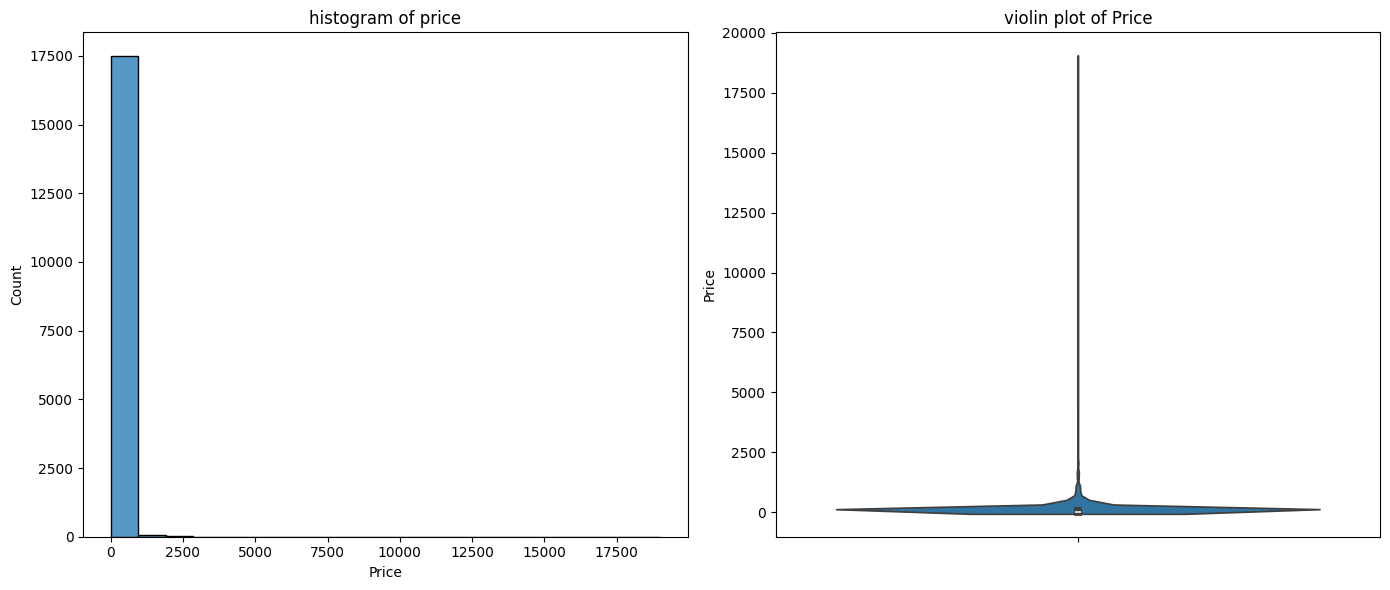

In [33]:
# visualize numeric fields
numerics_pdf = numerics.to_pandas()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot time on histogram
sns.histplot(numerics_pdf['Price'], bins=20, ax=axes[0])
axes[0].set_title('histogram of price')

# Plot time on violin plot
sns.violinplot(y=df['Price'], ax=axes[1])
axes[1].set_title('violin plot of Price')

# Display the plots
plt.tight_layout()
plt.show()

- High missing value rate (58.58% nulls - 24,857 out of 42,429 products)
- Extreme range from $0.01 to $18,999, with mean at $60.40
- Highly right-skewed distribution (histogram shows most values clustered near zero)
- Large standard deviation ($210.02) relative to median ($21.99)
- The violin plot reveals outliers extending to nearly $20,000, while most prices concentrate below $50

## conclusions

**Features to Included**

- Transformed Price: Log-transformed and normalized the price field despite 58.58% missing values, preserving nulls as meaningful signals
- Transformed Text Fields: Generated embeddings for Title, Features, and Description using DistilBERT, then applied dimensionality reduction (TruncatedSVD) to create 50 components for each field
- Details Fields: Created binary indicators (1/0) for presence/absence of each attribute in the Details structure, then applied SparsePCA to reduce from 172 sparse columns to 50 components

**Features to Excluded**

- SKU: Removed due to extremely high uniqueness (97.77%), which would lead to overfitting
- Manufacturer: Excluded as a standalone feature since the semantic information is captured in the text embeddings
- Raw Text Fields: Removed original text fields after embedding generation to reduce dimensionality

**Planned Feature Transformations**

- Price Field: Despite high missingness (58.58%), I'll apply log transformation and normalization while preserving nulls as potentially meaningful signals
- Text Fields: Will convert Title, Features, and Description into usable features, likely using embeddings or vectorization to capture their semantic content
- Details Structure: Plan to handle the nested structure by creating indicators for field presence/absence, then applying dimensionality reduction since there are too many sparse columns

**Implementation Considerations**

- Need to standardize inconsistent field naming across the dataset
- Must address redundant fields (like multiple dimension formats) through consolidation
- Will require dimensionality reduction techniques to handle the large feature space
- Text processing approach needs to capture semantic relationships while remaining computationally efficient